In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [59]:
df = pd.read_csv("data/Hobart_airport_daily_precip.csv")
dates = pd.to_datetime(df[['Year', 'Month', 'Day']])
df['dates'] = dates
df = df.set_index('dates')

In [60]:
# Clean up data frame
df = df.drop('Product code', 1)
df = df.drop('Bureau of Meteorology station number', 1)
df = df.rename(columns={'Rainfall amount (millimetres)': 'PPT', 'Period over which rainfall was measured (days)': 'period'})

In [61]:
dfa = df.resample('A').agg("sum")

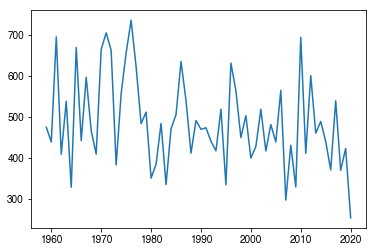

In [62]:
plt.plot(dfa.PPT)